In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
def plot_model_comparison(results_file="results/model_results.csv", final_results_file="results/final_results.csv"):
    """Plot comparison of different models"""
    
    # Load training curves
    df = pd.read_csv(results_file)
    
    # Plot training curves
    # Plot 1: Validation AUC over epochs
    plt.figure(figsize=(10, 6))
    for model_name in df['model_name'].unique():
        model_data = df[df['model_name'] == model_name]
        plt.plot(model_data['epoch'], model_data['val_auc'], label=model_name, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Validation AUC')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 2: Final test results
    plt.figure(figsize=(10, 6))
    final_df = pd.read_csv(final_results_file)
    plt.bar(final_df['model_name'], final_df['test_auc'])
    plt.ylabel('Test AUC')
    plt.title('Final Test Performance')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot 3: Precision vs Recall
    plt.figure(figsize=(8, 6))
    extended_mask = final_df['model_name'].str.contains('extended', case=False)
    limited_mask = final_df['model_name'].str.contains('limited', case=False)

    # Plot extended models in blue
    extended_data = final_df[extended_mask]
    plt.scatter(extended_data['test_recall'], extended_data['test_precision'], 
                s=100, alpha=0.7, color='blue', label='Extended Features')

    limited_data = final_df[limited_mask]
    plt.scatter(limited_data['test_recall'], limited_data['test_precision'], 
                s=100, alpha=0.7, color='red', label='Limited Features')

    other_mask = ~(extended_mask | limited_mask)
    if other_mask.any():
        other_data = final_df[other_mask]
        plt.scatter(other_data['test_recall'], other_data['test_precision'], 
                    s=100, alpha=0.7, color='gray', label='Other')
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision vs Recall by model feature size')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('images/precision_v_recall')
    plt.show()

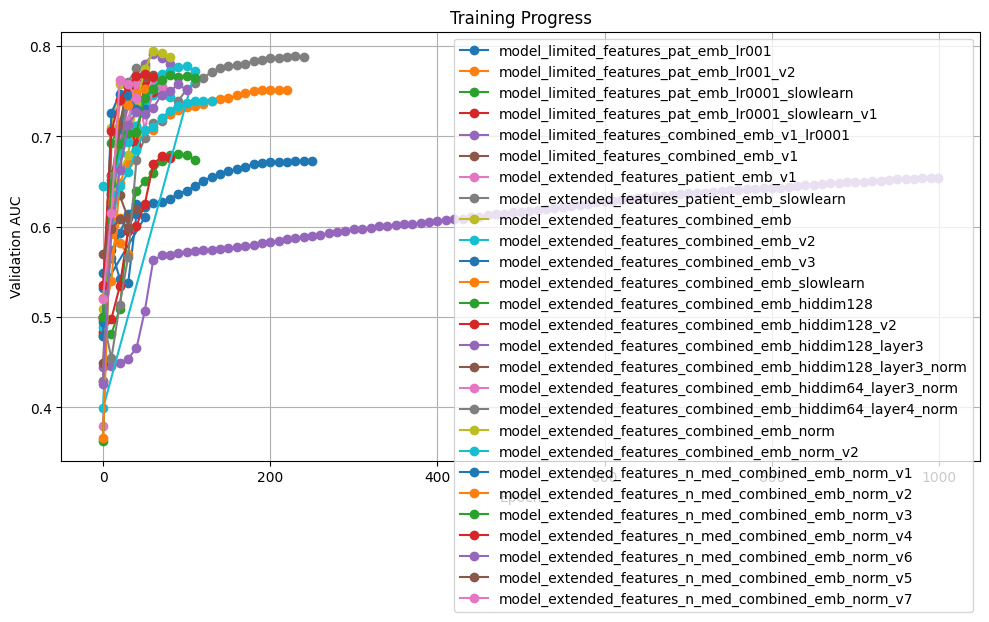

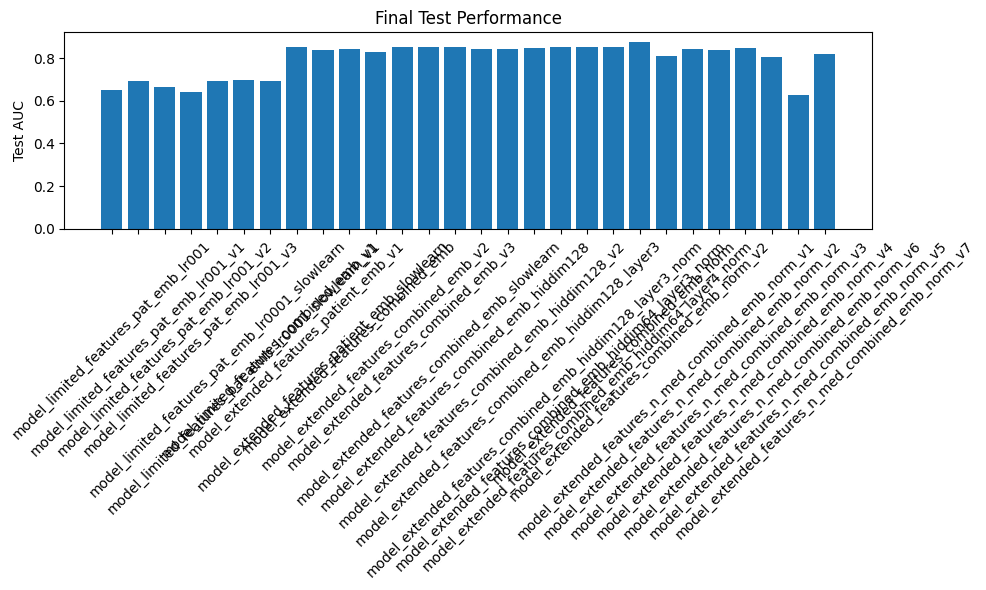

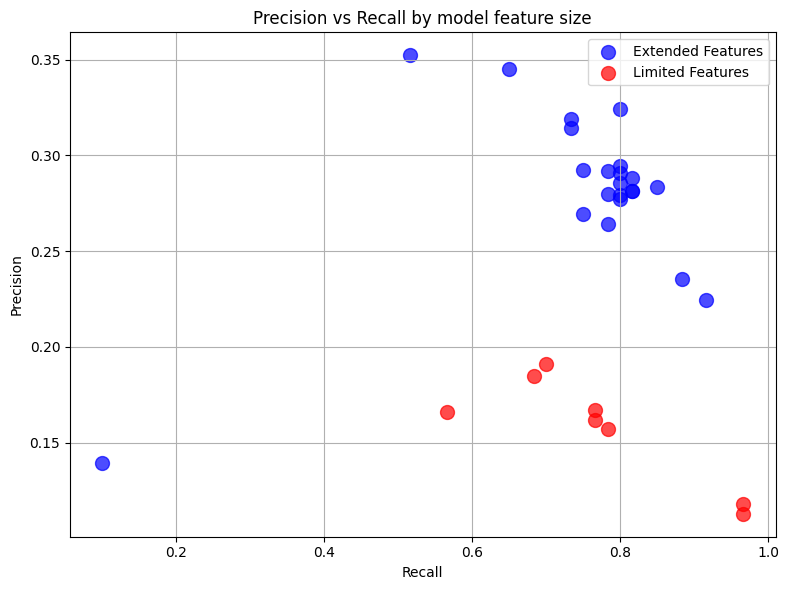

In [ ]:
# Use it like this:
# plot_model_comparison(results_file="results/model_results_v1.csv",final_results_file="results/final_results_v1.csv")
plot_model_comparison()

In [2]:
def print_model_comparison(final_results_file="results/final_results.csv"):
    """print a nice comparison table"""
    df = pd.read_csv(final_results_file)
    
    print("\nMODEL COMPARISON SUMMARY")
    print("=" * 80)
    
    comparison_df = df[['model_name', 'test_auc', 'test_precision','test_accuracy' ,'test_recall', 
                       'test_f1', 'predicted_positives', 'correct_positives']].copy()
    
    # round values
    for col in ['test_auc', 'test_precision','test_accuracy', 'test_recall', 'test_f1']:
        comparison_df[col] = comparison_df[col].round(3)
    
    print(comparison_df.to_string(index=False))
    
    # find best model
    best_auc = comparison_df.loc[comparison_df['test_auc'].idxmax()]
    print(f"\nBest AUC: {best_auc['model_name']} ({best_auc['test_auc']:.3f})")

    # comparison_df.to_csv("results/model_comparison.csv")

# print_model_comparison("results/final_results_v1.csv")
# print_model_comparison()

In [11]:
print_model_comparison("results/final_results_v1.csv")


MODEL COMPARISON SUMMARY
                                                model_name  test_auc  test_precision  test_accuracy  test_recall  test_f1  predicted_positives  correct_positives
                            model_limited_features_pat_emb     0.656           0.000          0.326        0.000        0                  427                 56
                  model_limited_features_slowlearn_pat_emb     0.500           0.000          0.237        0.000        0                  462                 49
                               model_more_features_pat_emb     0.771           0.000          0.721        0.000        0                  181                 43
                     model_more_features_slowlearn_pat_emb     0.802           0.000          0.701        0.000        0                  198                 46
                       model_limited_features_combined_emb     0.648           0.000          0.689        0.000        0                  165                 26
  

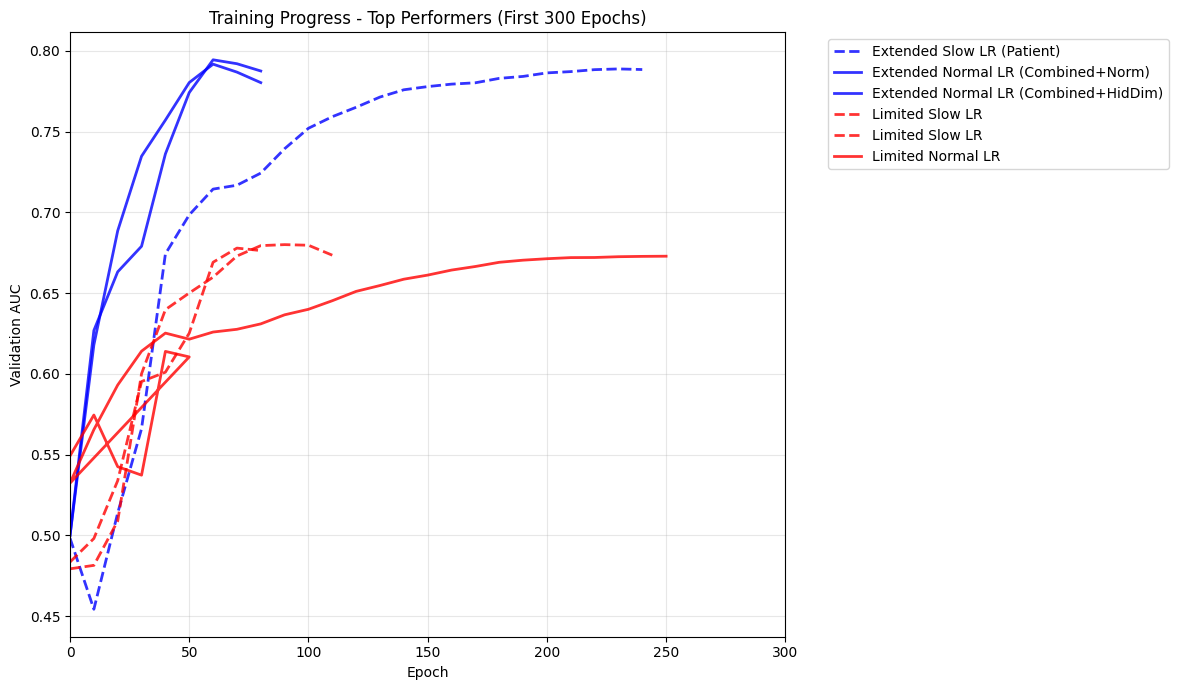

In [24]:
def plot_model_comparison_cleaned(results_file="results/model_results.csv", final_results_file="results/final_results.csv"):
    """Plot comparison of different models"""
    
    # Load training curves
    df = pd.read_csv(results_file)

    df_filtered = df[df['epoch'] <= 300]

    # Plot 1: Top performers with descriptive labels
    plt.figure(figsize=(12, 7))

    # Get the final performance for each model to select top performers
    model_final_auc = df_filtered.groupby('model_name')['val_auc'].last().sort_values(ascending=False)

    # Select top 3 extended and top 3 limited models
    extended_models = [m for m in model_final_auc.index if 'extended' in m.lower()][:3]
    limited_models = [m for m in model_final_auc.index if 'limited' in m.lower()][:3]
    selected_models = extended_models + limited_models

    for model_name in selected_models:
        model_data = df_filtered[df_filtered['model_name'] == model_name]
        
        # Extract meaningful features from model name
        if 'extended' in model_name.lower():
            color = 'blue'
            feature_type = 'Extended'
        else:
            color = 'red' 
            feature_type = 'Limited'
        
        # Extract learning rate info
        if 'slowlearn' in model_name.lower():
            linestyle = '--'
            lr_type = 'Slow LR'
        else:
            linestyle = '-'
            lr_type = 'Normal LR'
        
        # Extract other key info (embedding type, normalization, etc.)
        model_details = []
        if 'patient' in model_name.lower():
            model_details.append('Patient')
        if 'combined' in model_name.lower():
            model_details.append('Combined')
        if 'norm' in model_name.lower() and 'slowlearn' not in model_name.lower():
            model_details.append('Norm')
        if 'hiddim' in model_name.lower():
            model_details.append('HidDim')
        
        # Create descriptive label
        detail_str = '+'.join(model_details[:2])  # Limit to avoid too long labels
        label = f"{feature_type} {lr_type}" + (f" ({detail_str})" if detail_str else "")
        
        plt.plot(model_data['epoch'], model_data['val_auc'], 
                color=color, linestyle=linestyle, linewidth=2,
                label=label, alpha=0.8)

    plt.xlabel('Epoch')
    plt.ylabel('Validation AUC')
    plt.title('Training Progress - Top Performers (First 300 Epochs)')
    plt.xlim(0, 300)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('images/traning_progress_v1')
    plt.show()

plot_model_comparison_cleaned()

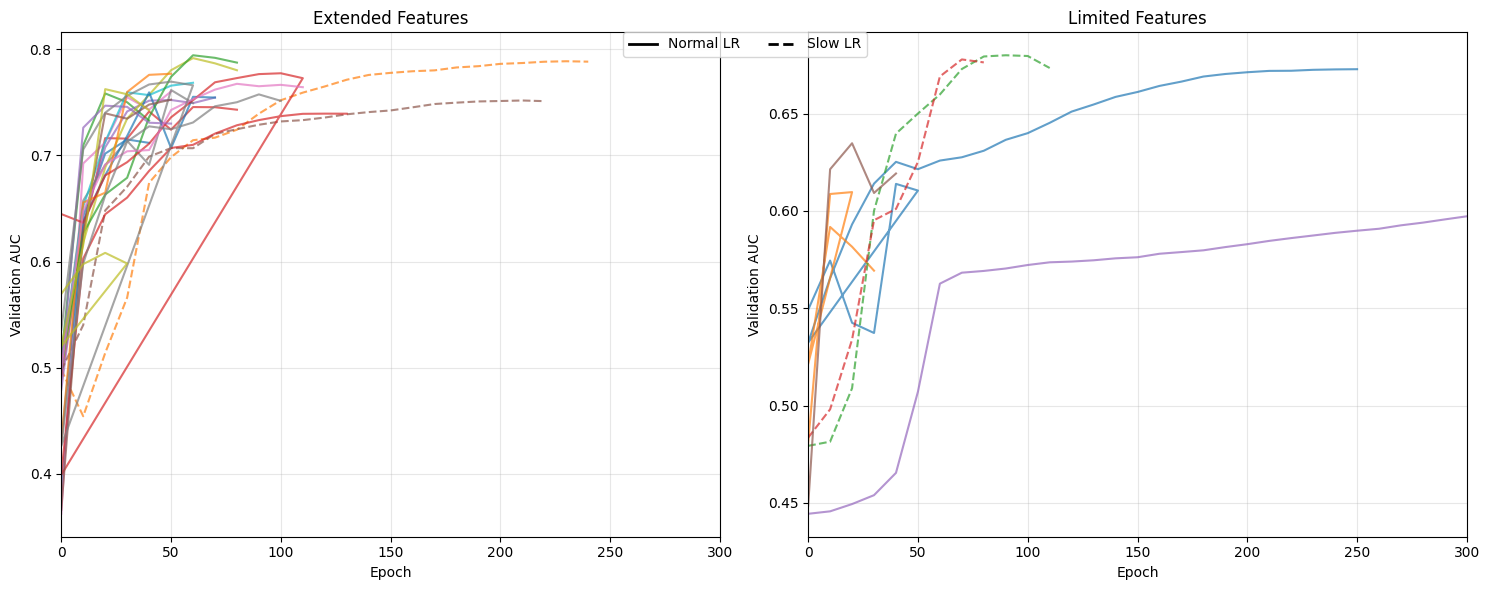

In [8]:
def plot_model_comparison_cleaned(results_file="results/model_results.csv", final_results_file="results/final_results.csv"):
    """Plot comparison of different models"""
    
    # Load training curves
    df = pd.read_csv(results_file)

    df_filtered = df[df['epoch'] <= 300]
    # Plot 1: Separate subplots for extended vs limited
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Extended models subplot
    extended_models = [m for m in df_filtered['model_name'].unique() if 'extended' in m.lower()]
    for model_name in extended_models:
        model_data = df_filtered[df_filtered['model_name'] == model_name]
        linestyle = '--' if 'slowlearn' in model_name.lower() else '-'
        ax1.plot(model_data['epoch'], model_data['val_auc'], 
                linestyle=linestyle, linewidth=1.5, alpha=0.7)

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Validation AUC')
    ax1.set_title('Extended Features')
    ax1.set_xlim(0, 300)
    ax1.grid(True, alpha=0.3)

    # Limited models subplot  
    limited_models = [m for m in df_filtered['model_name'].unique() if 'limited' in m.lower()]
    for model_name in limited_models:
        model_data = df_filtered[df_filtered['model_name'] == model_name]
        linestyle = '--' if 'slowlearn' in model_name.lower() else '-'
        ax2.plot(model_data['epoch'], model_data['val_auc'], 
                linestyle=linestyle, linewidth=1.5, alpha=0.7)

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Validation AUC')
    ax2.set_title('Limited Features')
    ax2.set_xlim(0, 300)
    ax2.grid(True, alpha=0.3)

    # Add legend for line styles
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='black', lw=2, linestyle='-', label='Normal LR'),
        Line2D([0], [0], color='black', lw=2, linestyle='--', label='Slow LR')
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2)

    plt.tight_layout()
    plt.show()

plot_model_comparison_cleaned()

In [ ]:
df = pd.read_csv("GraphPlayground/results/final_results.csv")
df2 = pd.read_csv()

In [ ]:
plot_model_comparison(results_file="results/model_results.csv", final_results_file="results/final_results.csv")

In [5]:
print_model_comparison(final_results_file="results/final_results_v6.csv")


MODEL COMPARISON SUMMARY
                                             model_name  test_auc  test_precision  test_accuracy  test_recall  test_f1  predicted_positives  correct_positives
     model_extended_features_n_med_combined_emb_norm_v5     0.846           0.268          0.734        0.850    0.408                  190                 51
model_extended_features_n_med_combined_emb_norm_pat_sim     0.846           0.268          0.721        0.917    0.415                  205                 55
            model_limited_features_combined_emb_lr_norm     0.573           0.000          0.892        0.000    0.000                    0                  0
                 model_limited_features_pat_emb_lr_norm     0.669           0.224          0.844        0.183    0.202                   49                 11
                 model_limited_features_pat_emb_lr_slow     0.641           0.138          0.390        0.883    0.238                  385                 53
                mode

In [3]:
print_model_comparison(final_results_file="results/final_results_updated.csv")


MODEL COMPARISON SUMMARY
                                                 model_name  test_auc  test_precision  test_accuracy  test_recall  test_f1  predicted_positives  correct_positives
         model_000_h64_numl2_lr0.0001_drop0_limited_pat_emb     0.655           0.146          0.482        0.783    0.246                  322                 47
          model_001_h64_numl2_lr0.001_drop0_limited_pat_emb     0.691           0.188          0.647        0.683    0.295                  218                 41
       model_002_h64_numl2_lr0.0001_drop0.1_limited_pat_emb     0.693           0.181          0.631        0.683    0.286                  227                 41
        model_003_h64_numl2_lr0.001_drop0.1_limited_pat_emb     0.672           0.146          0.493        0.767    0.246                  314                 46
       model_004_h64_numl2_lr0.0001_drop0.3_limited_pat_emb     0.673           0.149          0.520        0.733    0.248                  295                

The model configuration \verb|model_extended_features_n_med_combined_emb_norm_pat_sim| where the model uses an extended feature set, combined embeddings and a learning rate of 0.01 appears to be the best with AUC 0.846. While this is promising, it doens't surpass the result of \verb|model_extended_features_combined_emb_norm_v2| that uses the same model configuration with an AUC of 0.877. This suggests that the 

In [1]:
import pandas as pd
import numpy as np

In [9]:
print_model_comparison(final_results_file="results/final_results_test.csv")


MODEL COMPARISON SUMMARY
                                         model_name  test_auc  test_precision  test_accuracy  test_recall  test_f1  predicted_positives  correct_positives
 sweep_000_h32_numl2_lr0.0001_extended_combined_emb     0.850           0.294          0.773        0.783    0.427                  160                 47
  sweep_001_h32_numl2_lr0.001_extended_combined_emb     0.839           0.312          0.788        0.800    0.449                  154                 48
   sweep_002_h32_numl2_lr0.01_extended_combined_emb     0.846           0.298          0.775        0.800    0.434                  161                 48
 sweep_003_h32_numl3_lr0.0001_extended_combined_emb     0.545           0.110          0.421        0.617    0.187                  336                 37
  sweep_004_h32_numl3_lr0.001_extended_combined_emb     0.850           0.290          0.764        0.817    0.428                  169                 49
   sweep_005_h32_numl3_lr0.01_extended_combi

In [11]:
print_model_comparison(final_results_file="results/final_results_new.csv")


MODEL COMPARISON SUMMARY
                                                 model_name  test_auc  test_precision  test_accuracy  test_recall  test_f1  predicted_positives  correct_positives
         sweep_000_h64_numl2_lr0.0001_drop0_limited_pat_emb     0.655           0.146          0.482        0.783    0.246                  322                 47
          sweep_001_h64_numl2_lr0.001_drop0_limited_pat_emb     0.691           0.188          0.647        0.683    0.295                  218                 41
       sweep_002_h64_numl2_lr0.0001_drop0.1_limited_pat_emb     0.693           0.181          0.631        0.683    0.286                  227                 41
        sweep_003_h64_numl2_lr0.001_drop0.1_limited_pat_emb     0.672           0.146          0.493        0.767    0.246                  314                 46
       sweep_004_h64_numl2_lr0.0001_drop0.3_limited_pat_emb     0.673           0.149          0.520        0.733    0.248                  295                

In [12]:
df = pd.read_csv("results/final_results_new.csv")
df.columns

Index(['model_name', 'timestamp', 'test_auc', 'test_accuracy',
       'test_precision', 'test_recall', 'test_f1', 'predicted_positives',
       'true_positives', 'correct_positives', 'total_patients', 'hidden_dim',
       'num_layers', 'learning_rate', 'drop_out', 'total_epochs',
       'optimizer_type', 'pos_weight', 'model_description', 'device',
       'total_params'],
      dtype='object')

In [13]:
df = pd.read_csv("results/model_results_new.csv")
df.columns

Index(['model_name', 'epoch', 'timestamp', 'train_loss', 'train_auc',
       'train_accuracy', 'train_f1', 'train_precision', 'train_recall',
       'val_auc', 'val_accuracy', 'val_f1', 'val_precision', 'val_recall',
       'hidden_dim', 'num_layers', 'drop_out', 'learning_rate', 'total_epochs',
       'optimizer_type', 'pos_weight', 'model_description', 'device',
       'total_params'],
      dtype='object')

In [31]:
def create_paper_results_table(final_results_file):
    df = pd.read_csv(final_results_file)
    
    # Select key models for paper
    selected_models = []

    # for col in ['test_auc', 'test_precision','test_accuracy', 'test_recall', 'test_f1']:
    #     df[col] = df[col].round(3)
    
    # 1. Overall best
    best_overall = df.loc[df['test_auc'].idxmax()]
    selected_models.append(('Best Overall', best_overall))
    
    # 2. Best limited features
    limited_df = df[df['model_description'].str.contains('limited', case=False)]
    if not limited_df.empty:
        best_limited = limited_df.loc[limited_df['test_auc'].idxmax()]
        selected_models.append(('Best Limited Features', best_limited))
    
    # 3. Best extended features  
    extended_df = df[df['model_description'].str.contains('extended', case=False)]
    if not extended_df.empty:
        best_extended = extended_df.loc[extended_df['test_auc'].idxmax()]
        selected_models.append(('Best Extended Features', best_extended))
    
    # 4. Key architectural comparisons (different layer/hidden combinations)
    for layers in [2, 3]:  # assuming you tested these
        layer_subset = df[df['num_layers'] == layers]
        if not layer_subset.empty:
            best_for_layers = layer_subset.loc[layer_subset['test_auc'].idxmax()]
            selected_models.append((f'{layers}-Layer Best', best_for_layers))

    # 5. Efficiency comparison - best performance per parameter
    df['auc_per_param'] = df['test_auc'] / df['total_params']
    most_efficient = df.loc[df['auc_per_param'].idxmax()]
    selected_models.append(('Most Efficient', most_efficient))

    # 6. Clinical relevance - highest precision (fewer false positives)
    highest_precision = df.loc[df['test_precision'].idxmax()]
    selected_models.append(('Highest Precision', highest_precision))

    # 7. Clinical coverage - highest recall (catch more cases)
    highest_recall = df.loc[df['test_recall'].idxmax()]
    selected_models.append(('Highest Recall', highest_recall))

    # 8. Dropout effect demonstration
    no_dropout = df[df['drop_out'] == 0.0]
    with_dropout = df[df['drop_out'] > 0.0]
    if not no_dropout.empty and not with_dropout.empty:
        best_no_dropout = no_dropout.loc[no_dropout['test_auc'].idxmax()]
        best_with_dropout = with_dropout.loc[with_dropout['test_auc'].idxmax()]
        selected_models.extend([
            ('Best w/o Dropout', best_no_dropout),
            ('Best w/ Dropout', best_with_dropout)
        ])

    # 9. Learning rate effect (extremes)
    slowest_lr = df.loc[df['learning_rate'].idxmin()]
    fastest_lr = df.loc[df['learning_rate'].idxmax()]
    selected_models.extend([
        ('Slowest LR', slowest_lr),
        ('Fastest LR', fastest_lr)
    ])

    # 10. Balanced F1 performance
    best_f1 = df.loc[df['test_f1'].idxmax()]
    selected_models.append(('Best F1 Score', best_f1))
    
    # Create clean table
    table_data = []
    for name, model in selected_models:
        table_data.append({
            'Model': name,
            'Hidden Dim': int(model['hidden_dim']),
            'Layers': int(model['num_layers']),
            'Learning Rate': f"{model['learning_rate']}",
            'Dropout': f"{model.get('drop_out', 0):.1f}",
            'Test AUC': f"{model['test_auc']:.3f}",
            'Precision': f"{model['test_precision']:.3f}",
            'Recall': f"{model['test_recall']:.3f}",
            'F1': f"{model['test_f1']:.3f}",
            'Predicted+': f"{model['predicted_positives']}",
            'Correct+': f"{model['correct_positives']}",
            'True+': f"{model['true_positives']:.0f}",
            # 'Model Name': f"{model['model_name']}"
            'Accuracy': f"{model['test_accuracy']}"
        })
    
    result_df = pd.DataFrame(table_data)
    print(result_df.to_string(index=False))
    return result_df


# print_model_comparison(final_results_file="results/final_results_updated.csv")

In [32]:
create_paper_results_table(final_results_file="results/final_results_updated.csv")

                 Model  Hidden Dim  Layers Learning Rate Dropout Test AUC Precision Recall    F1 Predicted+ Correct+ True+           Accuracy
          Best Overall         128       2         0.001     0.1    0.873     0.293  0.850 0.436        174       51    60  0.762589928057554
 Best Limited Features         128       2         0.001     0.5    0.703     0.192  0.733 0.304        229       44    60 0.6384892086330936
Best Extended Features         128       2         0.001     0.1    0.873     0.293  0.850 0.436        174       51    60  0.762589928057554
          2-Layer Best         128       2         0.001     0.1    0.873     0.293  0.850 0.436        174       51    60  0.762589928057554
          3-Layer Best         128       3        0.0001     0.3    0.872     0.266  0.833 0.403        188       50    60 0.7338129496402878
        Most Efficient          64       2         0.001     0.1    0.873     0.300  0.900 0.450        180       54    60  0.762589928057554
     H

,Model,Hidden Dim,Layers,Learning Rate,Dropout,Test AUC,Precision,Recall,F1,Predicted+,Correct+,True+,Accuracy
0,Best Overall,128,2,0.001,0.1,0.873,0.293,0.850,0.436,174,51,60,0.762589928057554
1,Best Limited Features,128,2,0.001,0.5,0.703,0.192,0.733,0.304,229,44,60,0.6384892086330936
2,Best Extended Features,128,2,0.001,0.1,0.873,0.293,0.850,0.436,174,51,60,0.762589928057554
3,2-Layer Best,128,2,0.001,0.1,0.873,0.293,0.850,0.436,174,51,60,0.762589928057554
4,3-Layer Best,128,3,0.0001,0.3,0.872,0.266,0.833,0.403,188,50,60,0.7338129496402878
5,Most Efficient,64,2,0.001,0.1,0.873,0.300,0.900,0.450,180,54,60,0.762589928057554
6,Highest Precision,64,2,0.001,0.1,0.851,0.374,0.617,0.465,99,37,60,0.8471223021582733
7,Highest Recall,128,2,0.001,0.1,0.613,0.108,1.000,0.195,556,60,60,0.1079136690647482
8,Best w/o Dropout,64,2,0.001,0.0,0.873,0.308,0.817,0.447,159,49,60,0.7823741007194245
9,Best w/ Dropout,128,2,0.001,0.1,0.873,0.293,0.850,0.436,174,51,60,0.762589928057554


In [33]:
create_paper_results_table(final_results_file="results/final_results_patsim.csv")

                 Model  Hidden Dim  Layers Learning Rate Dropout Test AUC Precision Recall    F1 Predicted+ Correct+ True+           Accuracy
          Best Overall          64       2         0.001     0.1    0.869     0.292  0.833 0.433        171       50    60 0.7643884892086331
 Best Limited Features          64       2         0.001     0.0    0.692     0.194  0.700 0.304        216       42    60 0.6546762589928058
Best Extended Features          64       2         0.001     0.1    0.869     0.292  0.833 0.433        171       50    60 0.7643884892086331
          2-Layer Best          64       2         0.001     0.1    0.869     0.292  0.833 0.433        171       50    60 0.7643884892086331
          3-Layer Best          64       3         0.001     0.0    0.858     0.277  0.817 0.414        177       49    60               0.75
        Most Efficient          64       2         0.001     0.1    0.869     0.292  0.833 0.433        171       50    60 0.7643884892086331
     H

,Model,Hidden Dim,Layers,Learning Rate,Dropout,Test AUC,Precision,Recall,F1,Predicted+,Correct+,True+,Accuracy
0,Best Overall,64,2,0.001,0.1,0.869,0.292,0.833,0.433,171,50,60,0.7643884892086331
1,Best Limited Features,64,2,0.001,0.0,0.692,0.194,0.700,0.304,216,42,60,0.6546762589928058
2,Best Extended Features,64,2,0.001,0.1,0.869,0.292,0.833,0.433,171,50,60,0.7643884892086331
3,2-Layer Best,64,2,0.001,0.1,0.869,0.292,0.833,0.433,171,50,60,0.7643884892086331
4,3-Layer Best,64,3,0.001,0.0,0.858,0.277,0.817,0.414,177,49,60,0.75
5,Most Efficient,64,2,0.001,0.1,0.869,0.292,0.833,0.433,171,50,60,0.7643884892086331
6,Highest Precision,128,2,0.0001,0.5,0.852,0.363,0.683,0.474,113,41,60,0.8363309352517986
7,Highest Recall,64,3,0.001,0.1,0.583,0.108,1.000,0.195,554,60,60,0.1115107913669064
8,Best w/o Dropout,128,2,0.001,0.0,0.867,0.299,0.833,0.441,167,50,60,0.7715827338129496
9,Best w/ Dropout,64,2,0.001,0.1,0.869,0.292,0.833,0.433,171,50,60,0.7643884892086331


In [34]:
def calculate_feature_group_means(final_results_file="results/final_results.csv"):
    df = pd.read_csv(final_results_file)
    
    # Group by feature type
    limited_mask = df['model_description'].str.contains('limited', case=False, na=False)
    extended_mask = df['model_description'].str.contains('extended', case=False, na=False)
    
    limited_mean = df[limited_mask]['test_auc'].mean()
    extended_mean = df[extended_mask]['test_auc'].mean()
    
    limited_count = limited_mask.sum()
    extended_count = extended_mask.sum()
    
    print(f"Limited Features  - Mean AUC: {limited_mean:.3f} (n={limited_count})")
    print(f"Extended Features - Mean AUC: {extended_mean:.3f} (n={extended_count})")
    print(f"Difference: {extended_mean - limited_mean:.3f}")
    
    return limited_mean, extended_mean

# Usage
limited_auc, extended_auc = calculate_feature_group_means("results/final_results_updated.csv")

Limited Features  - Mean AUC: 0.642 (n=64)
Extended Features - Mean AUC: 0.847 (n=64)
Difference: 0.205


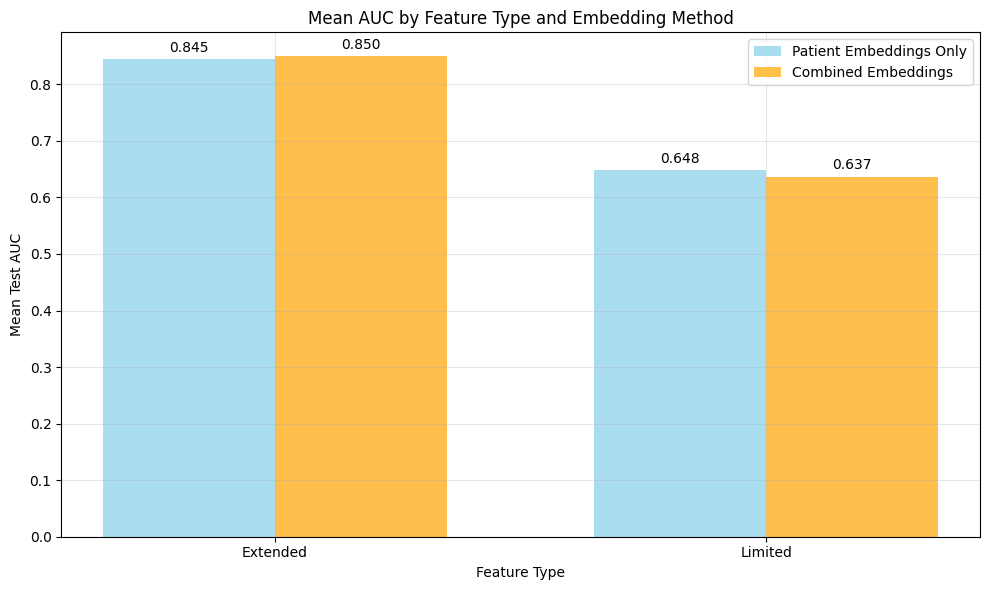

Mean AUC Summary:
Extended + Combined: 0.850 (n=32)
Extended + Patient Only: 0.845 (n=32)
Limited + Combined: 0.637 (n=32)
Limited + Patient Only: 0.648 (n=32)


In [37]:
def plot_feature_embedding_comparison(final_results_file="results/final_results_updated.csv"):
    df = pd.read_csv(final_results_file)
    
    # Create feature type groups
    df['feature_type'] = df['model_description'].apply(
        lambda x: 'Extended' if 'extended' in x.lower() else 'Limited' if 'limited' in x.lower() else 'Other'
    )
    
    # Create embedding type groups
    df['embedding_type'] = df['model_name'].apply(
        lambda x: 'Patient Only' if 'pat_emb' in x else 'Combined' if 'combined_emb' in x else 'Other'
    )
    
    # Calculate means for each combination
    grouped = df.groupby(['feature_type', 'embedding_type'])['test_auc'].agg(['mean', 'count']).reset_index()
    grouped = grouped[grouped['feature_type'].isin(['Limited', 'Extended'])]
    grouped = grouped[grouped['embedding_type'].isin(['Patient Only', 'Combined'])]
    
    # Create grouped bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(grouped['feature_type'].unique()))
    width = 0.35
    
    # Get data for each embedding type
    patient_data = grouped[grouped['embedding_type'] == 'Patient Only']
    combined_data = grouped[grouped['embedding_type'] == 'Combined']
    
    bars1 = ax.bar(x - width/2, patient_data['mean'], width, 
                   label='Patient Embeddings Only', alpha=0.7, color='skyblue')
    bars2 = ax.bar(x + width/2, combined_data['mean'], width,
                   label='Combined Embeddings', alpha=0.7, color='orange')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=10)
    
    ax.set_xlabel('Feature Type')
    ax.set_ylabel('Mean Test AUC')
    ax.set_title('Mean AUC by Feature Type and Embedding Method')
    ax.set_xticks(x)
    ax.set_xticklabels(patient_data['feature_type'])
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("Mean AUC Summary:")
    for _, row in grouped.iterrows():
        print(f"{row['feature_type']} + {row['embedding_type']}: {row['mean']:.3f} (n={row['count']})")

# Usage
plot_feature_embedding_comparison()

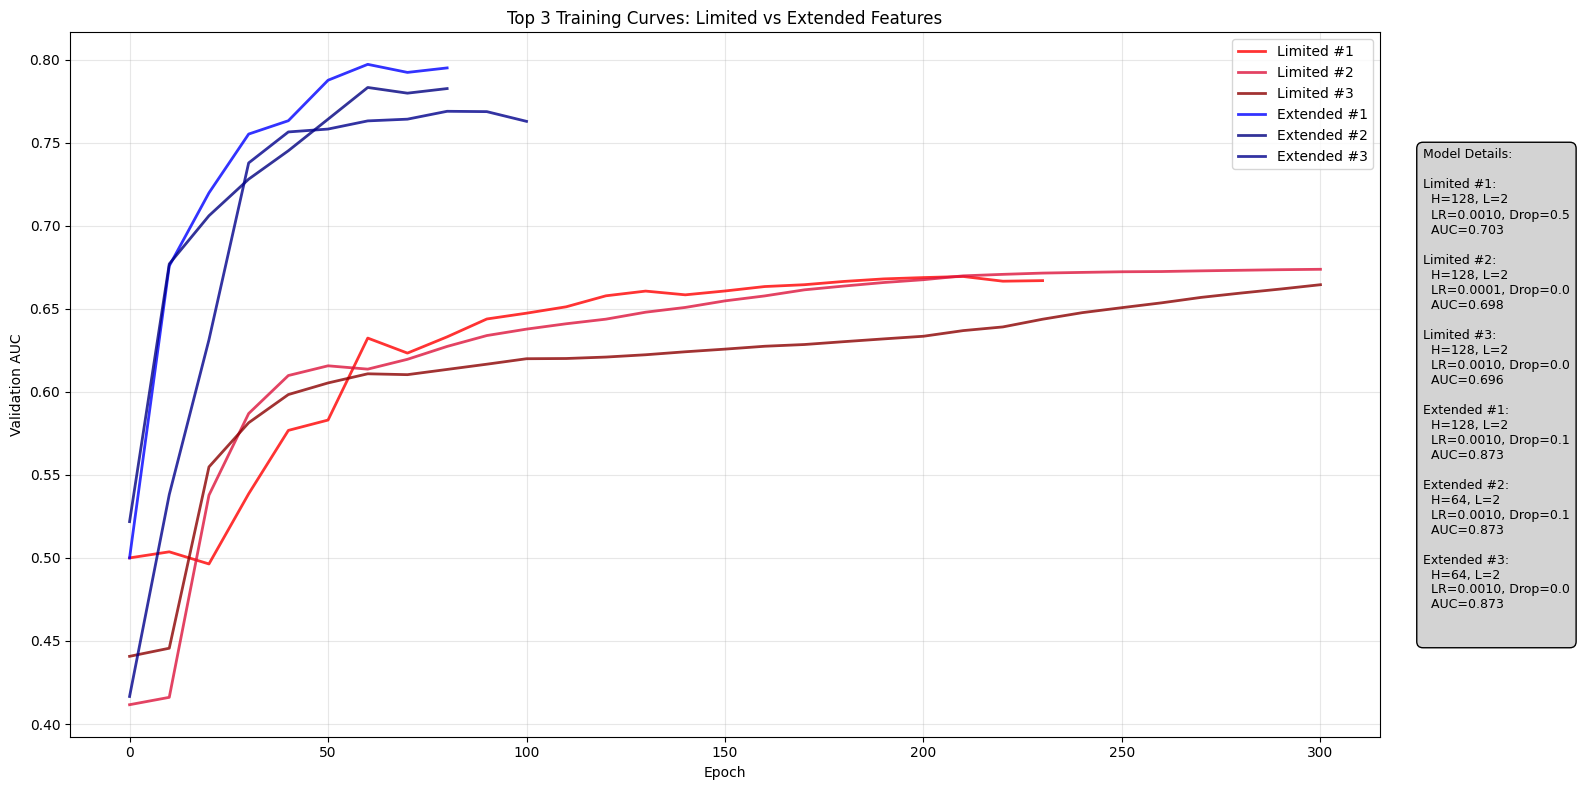

In [43]:
def plot_top_training_curves(results_file="results/model_results_updated.csv", 
                           final_results_file="results/final_results_updated.csv"):
    # Get top 3 models for each feature type
    final_df = pd.read_csv(final_results_file)
    train_df = pd.read_csv(results_file)

    train_df = train_df[train_df['epoch'] <= 300]
    
    limited_df = final_df[final_df['model_description'].str.contains('limited', case=False)]
    extended_df = final_df[final_df['model_description'].str.contains('extended', case=False)]
    
    top_limited = limited_df.nlargest(3, 'test_auc')['model_name'].tolist()
    top_extended = extended_df.nlargest(3, 'test_auc')['model_name'].tolist()
    
    # Create plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot limited models (red shades)
    red_colors = ['red', 'crimson', 'darkred']
    for i, model in enumerate(top_limited):
        model_data = train_df[train_df['model_name'] == model]
        ax.plot(model_data['epoch'], model_data['val_auc'], 
               color=red_colors[i], linewidth=2, alpha=0.8, 
               label=f'Limited #{i+1}')
    
    # Plot extended models (blue shades)  
    blue_colors = ['blue', 'navy', 'darkblue']
    for i, model in enumerate(top_extended):
        model_data = train_df[train_df['model_name'] == model]
        ax.plot(model_data['epoch'], model_data['val_auc'], 
               color=blue_colors[i], linewidth=2, alpha=0.8,
               label=f'Extended #{i+1}')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Validation AUC')
    ax.set_title('Top 3 Training Curves: Limited vs Extended Features')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    
    # Create metrics legend on the right
    legend_text = "Model Details:\n\n"
    
    for i, model in enumerate(top_limited):
        model_info = final_df[final_df['model_name'] == model].iloc[0]
        legend_text += f"Limited #{i+1}:\n"
        legend_text += f"  H={int(model_info['hidden_dim'])}, L={int(model_info['num_layers'])}\n"
        legend_text += f"  LR={model_info['learning_rate']:.4f}, Drop={model_info.get('drop_out', 0):.1f}\n"
        legend_text += f"  AUC={model_info['test_auc']:.3f}\n\n"
    
    for i, model in enumerate(top_extended):
        model_info = final_df[final_df['model_name'] == model].iloc[0]
        legend_text += f"Extended #{i+1}:\n"
        legend_text += f"  H={int(model_info['hidden_dim'])}, L={int(model_info['num_layers'])}\n"
        legend_text += f"  LR={model_info['learning_rate']:.4f}, Drop={model_info.get('drop_out', 0):.1f}\n"
        legend_text += f"  AUC={model_info['test_auc']:.3f}\n\n"
    
    # Add legend box outside plot
    plt.figtext(1.02, 0.5, legend_text, fontsize=9, 
               bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray"),
               verticalalignment='center')
    
    plt.subplots_adjust(right=0.65)  # Make room for legend
    plt.tight_layout()
    plt.savefig("images/top_3_training.png", bbox_inches="tight")
    plt.show()

# Usage
plot_top_training_curves()